# Core plotting functions

**Author:** [Fidel Ramírez](https://github.com/fidelram)

This tutorial explores the visualization possibilities of scanpy and is divided into three sections:

 * Scatter plots for embeddings (eg. UMAP, t-SNE)
 * Identification of clusters using known marker genes
 * Visualization of differentially expressed genes

In this tutorial, we will use a dataset from 10x containing 68k cells from [PBMC](https://support.10xgenomics.com/single-cell-gene-expression/datasets). Scanpy, includes in its distribution a reduced sample of this dataset consisting of only 700 cells and 765 highly variable genes. This dataset has been already preprocessed and UMAP computed.

In this tutorial, we will also use the following literature markers:

* **B-cell**: CD79A, MS4A1
* **Plasma**: IGJ (JCHAIN)
* **T-cell**: CD3D
* **NK**: GNLY, NKG7
* **Myeloid**: CST3, LYZ
* **Monocytes**: FCGR3A
* **Dendritic**: FCER1A

## Scatter plots for embeddings

With scanpy, scatter plots for tSNE, UMAP and several other embeddings are readily available using the `sc.pl.tsne`, `sc.pl.umap` etc. functions. See [here](https://scanpy.readthedocs.io/en/stable/api/scanpy.plotting.html#embeddings) the list of options.

Those functions access the data stored in `adata.obsm`. For example `sc.pl.umap` uses the information stored in `adata.obsm['X_umap']`. For more flexibility, any key stored in `adata.obsm` can be used with the generic function `sc.pl.embedding`.

In [1]:
import scanpy as sc
import pandas as pd
from matplotlib.pyplot import rc_context
import scipy
import anndata
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
sc.set_figure_params(dpi=100, color_map = 'viridis_r')
sc.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.24.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 pynndescent==0.5.10


In [3]:
# configuration for capsule
from pathlib import Path

sc._settings.ScanpyConfig.cachedir = Path("/data/cache/")
sc._settings.ScanpyConfig.datasetdir = Path("/data/")
Path("/results/figures").mkdir(parents=True, exist_ok=True)
sc._settings.ScanpyConfig.figdir = Path("/results/figures")
Path("/results/write").mkdir(parents=True, exist_ok=True)
sc._settings.ScanpyConfig.writedir = Path("/results/write/")

### Load pbmc dataset

In [4]:
# cells = pd.read_csv("/data/input_data/barcodes.tsv",sep="\t",header=None)
# genes = pd.read_csv("/data/input_data/features.tsv",sep="\t",header=None)
# pbmc = scipy.io.mmread("/data/input_data/matrix.mtx")

cells = pd.read_csv("/data/INCF_10X_data/barcodes.tsv.gz",sep="\t",header=None)
genes = pd.read_csv("/data/INCF_10X_data/features.tsv.gz",sep="\t",header=None)
pbmc = scipy.io.mmread("/data/INCF_10X_data/matrix.mtx.gz")

In [5]:
pbmc = pd.DataFrame.sparse.from_spmatrix(pbmc)
#pbmc = pbmc[list(range(0,500))].head(500)

In [6]:
pbmc.columns = cells[0].tolist()
pbmc.index = genes[1].tolist()

In [7]:
pbmc = anndata.AnnData(pbmc.transpose())

In [8]:
# inspect pbmc contents
pbmc

AnnData object with n_obs × n_vars = 7889 × 36601

### Visualization of gene expression and other variables

For the scatter plots, the value to plot is given as the `color` argument. This can be any gene or any column in `.obs`, where `.obs` is a DataFrame containing the annotations per observation/cell, see [AnnData](https://anndata.readthedocs.io/en/stable/) for more information.

In [9]:
sc.pp.log1p(pbmc)

In [10]:
sc.pp.neighbors(pbmc)
sc.tl.umap(pbmc)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [11]:
umap = pd.read_csv("/data/input_data/projection.csv",index_col=0)

In [12]:
clusters = pd.read_csv("/data/input_data/clusters.csv",index_col=0)

In [13]:
pbmc.obsm["X_umap"].shape

(7889, 2)

In [14]:
os.chdir("/results")

# Replacement for knowing marker genes

In [15]:
sc.pp.highly_variable_genes(pbmc)

In [16]:
variable_genes = pbmc.var[pbmc.var["highly_variable"]==True].index.tolist()

Multiple values can be given to `color`. In the following example we will plot 6 genes: 'CD79A', 'MS4A1', 'IGJ', CD3D', 'FCER1A', and 'FCGR3A' to get an idea on where those marker genes are being expressed.

Also, we will plot two other values: `n_counts` which is the number of UMI counts per cell (stored in `.obs`), and `bulk_labels` which is a categorical value containing the original labelling of the cells from 10X. 

The number of plots per row is controlled using the `ncols` parameter. The maximum value plotted can be adjusted using `vmax` (similarly `vmin` can be used for the minimum value). In this case we use `p99`, which means to use as max value the 99 percentile. The max value can be a number or a list of numbers if the vmax wants to be set for multiple plots individually.

Also, we are using `frameon=False` to remove the boxes around the plots and `s=50` to set the dot size.



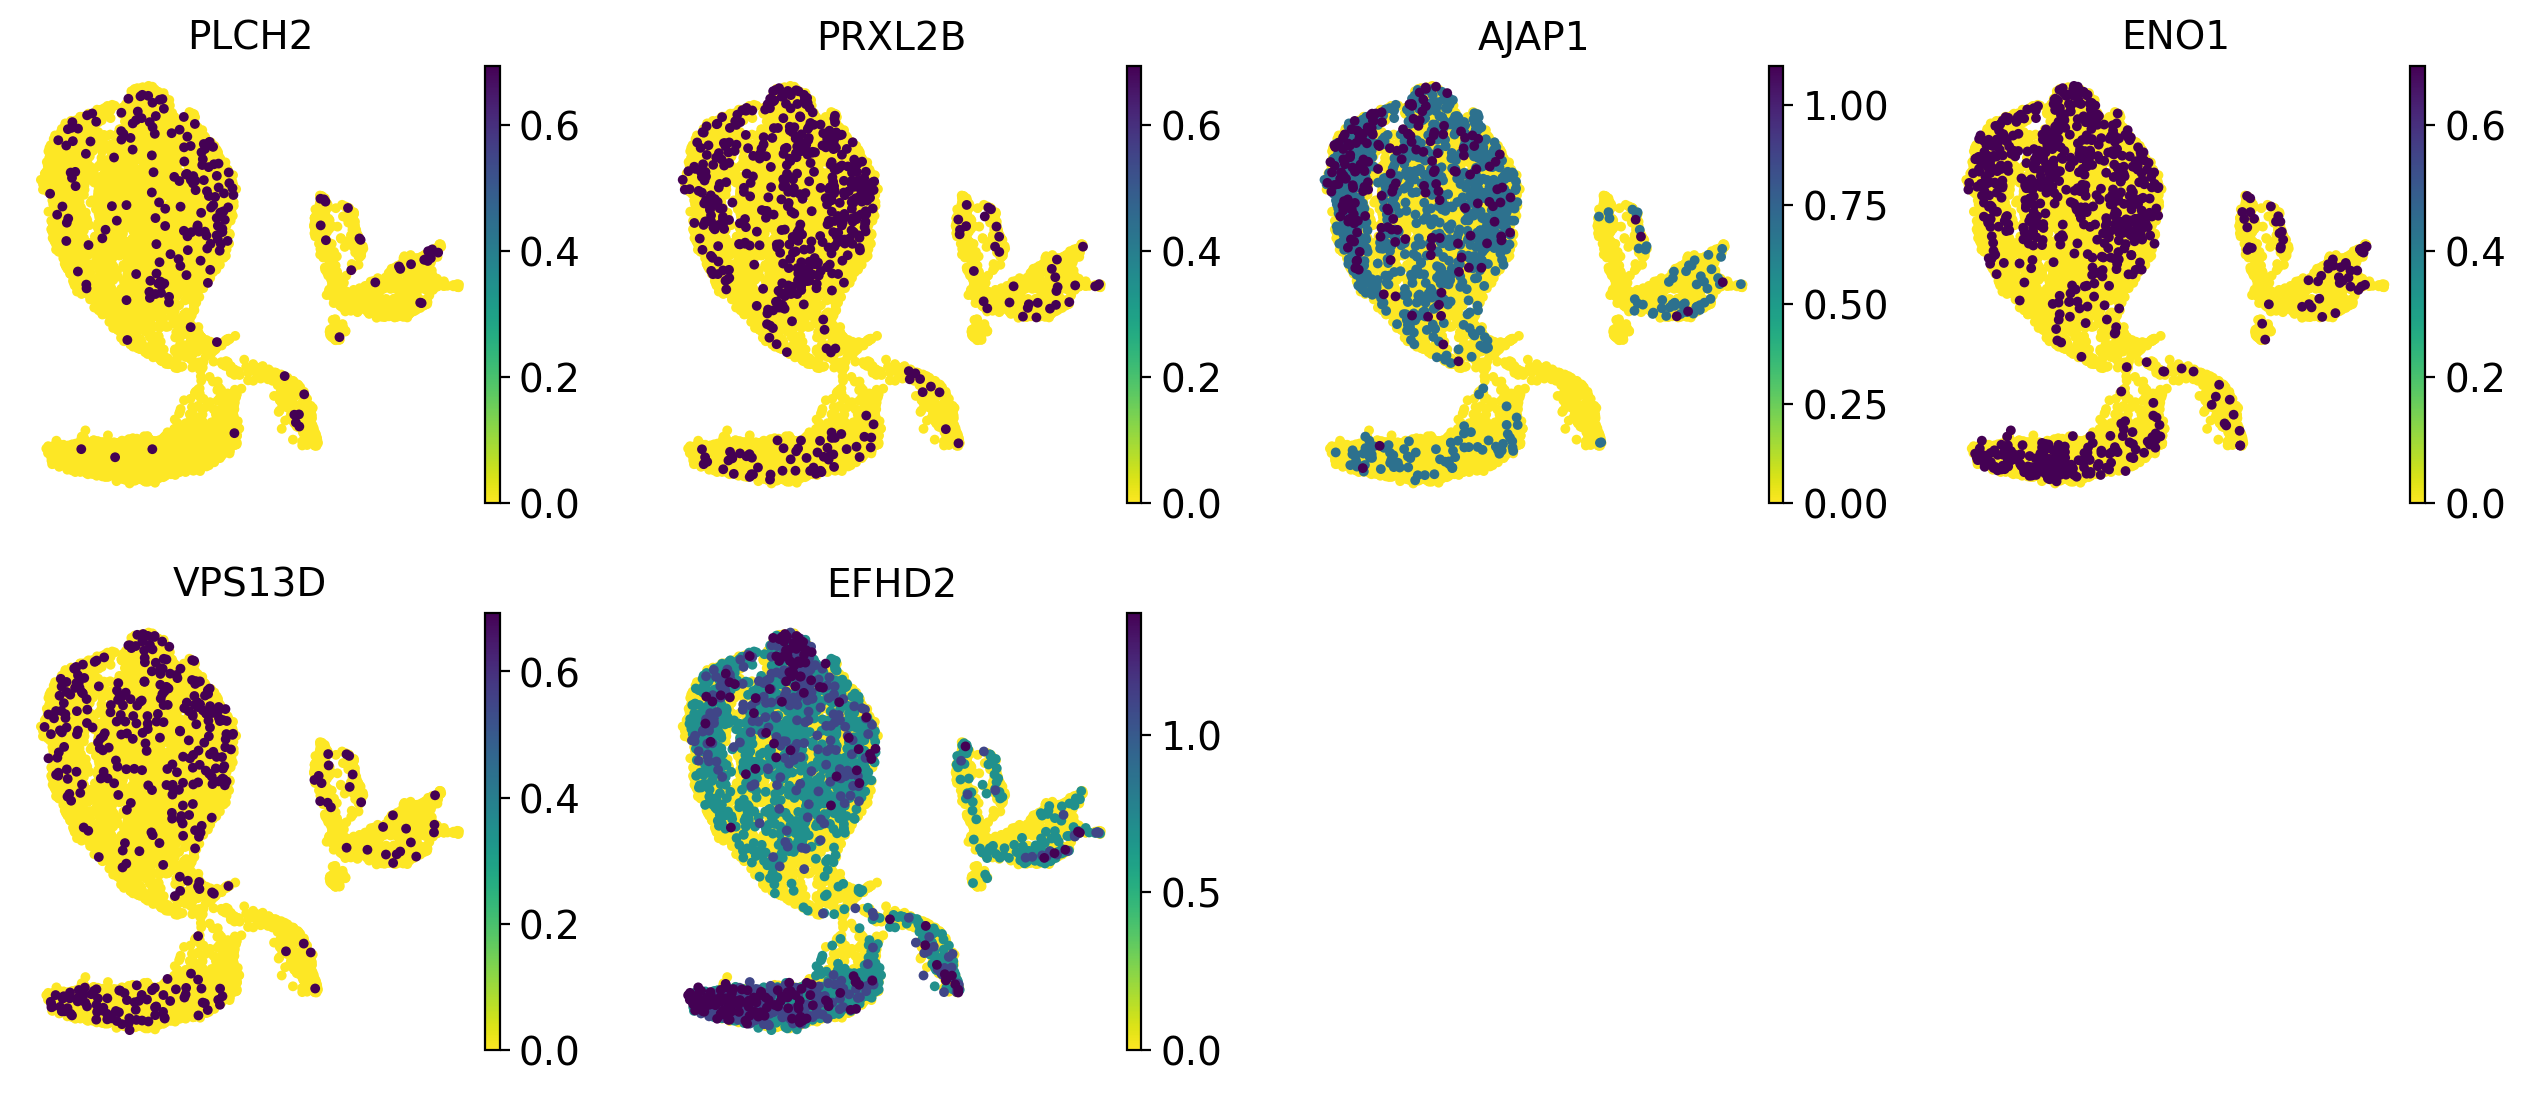

In [17]:
with rc_context({'figure.figsize': (3, 3)}):
    sc.pl.umap(pbmc, color=variable_genes[:6], s=50, frameon=False, ncols=4, vmax='p99',save="_genes.png") 

In this plot we can see the groups of cells that express the marker genes and the agreement with the original cell labels.

The functions for scatterplots have many options that allow fine tuning of the images. For example, we can look at the clustering as follows:

In [18]:
pbmc.obs["clusters"] = clusters["Cluster"].tolist()

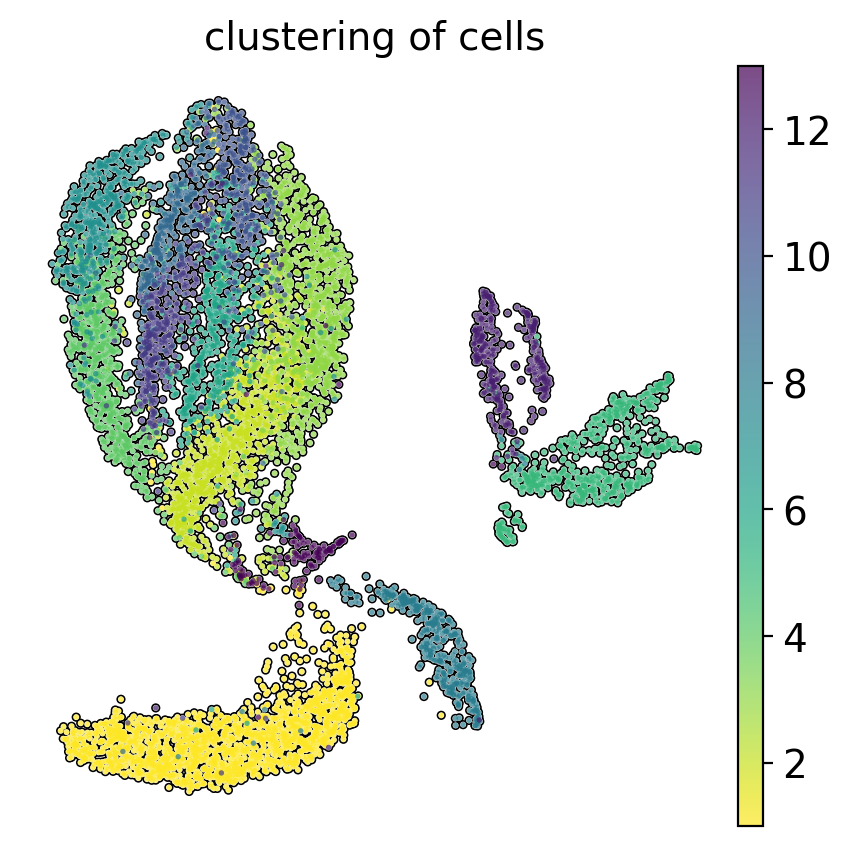

In [19]:
with rc_context({'figure.figsize': (5, 5)}):
    sc.pl.umap(pbmc, color='clusters', add_outline=True, legend_loc='on data', 
               legend_fontsize=12, legend_fontoutline=2,frameon=False,  
               title='clustering of cells', palette='Set1') 

## Identification of clusters based on known marker genes (not including in tutorial)

Frequently, clusters need to be labelled using well known marker genes. Using scatter plots we can see the expression of a gene and perhaps associate it with a cluster. Here, we will show other visual ways to associate marker genes to clusters using *dotplots*, *violin plots*, *heatmaps* and something that we call '*tracksplot*'. All of these visualizations summarize the same information, expression split by cluster, and the selection of the best results is left to the investigator do decide.
 
First, we set up a dictionary with the marker genes, as this will allow scanpy to automatically label the groups of genes:


In [20]:
pbmc.obs["clusters"] = [str(i) for i in pbmc.obs["clusters"].tolist()]

Using this plot, we can see that cluster 4 correspond to B-cells, cluster 2 is T-cells etc. This information can be used to manually annotate the cells as follows:

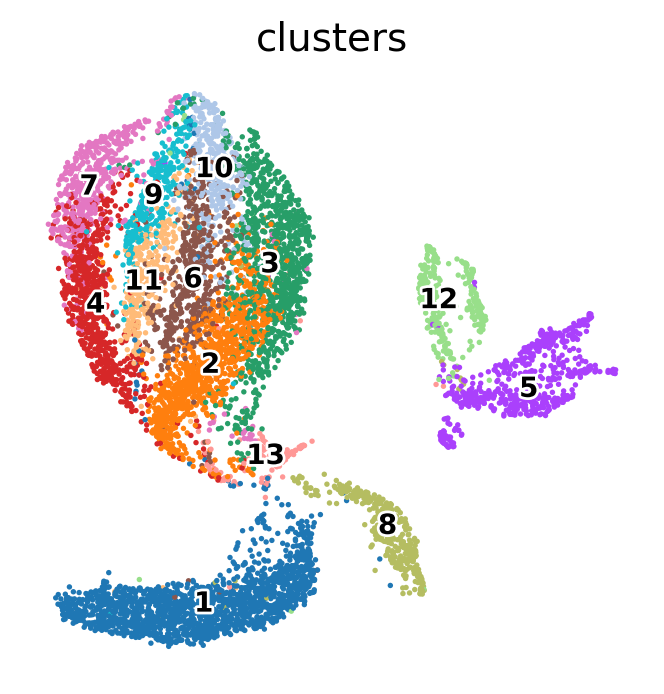

In [21]:
sc.pl.umap(pbmc, color='clusters', legend_loc='on data',
           frameon=False, legend_fontsize=10, legend_fontoutline=2)

## Visualization of marker genes

Instead of characterizing clusters by known gene markers as previously, we can identify genes that are differentially expressed in the clusters or groups.


To identify differentially expressed genes we run `sc.tl.rank_genes_groups`. This function will take each group of cells and compare the distribution of each gene in a group against the distribution in all other cells not in the group. Here, we will use the original cell labels given by 10x to identify marker genes for those cell types.

In [22]:
sc.tl.rank_genes_groups(pbmc, groupby='clusters', method='wilcoxon')

### Visualize marker genes using dotplot

The dotplot visualization is useful to get an overview of the genes that show differential expression. To make the resulting image more compact we will use `n_genes=4` to show only the top 4 scoring genes.

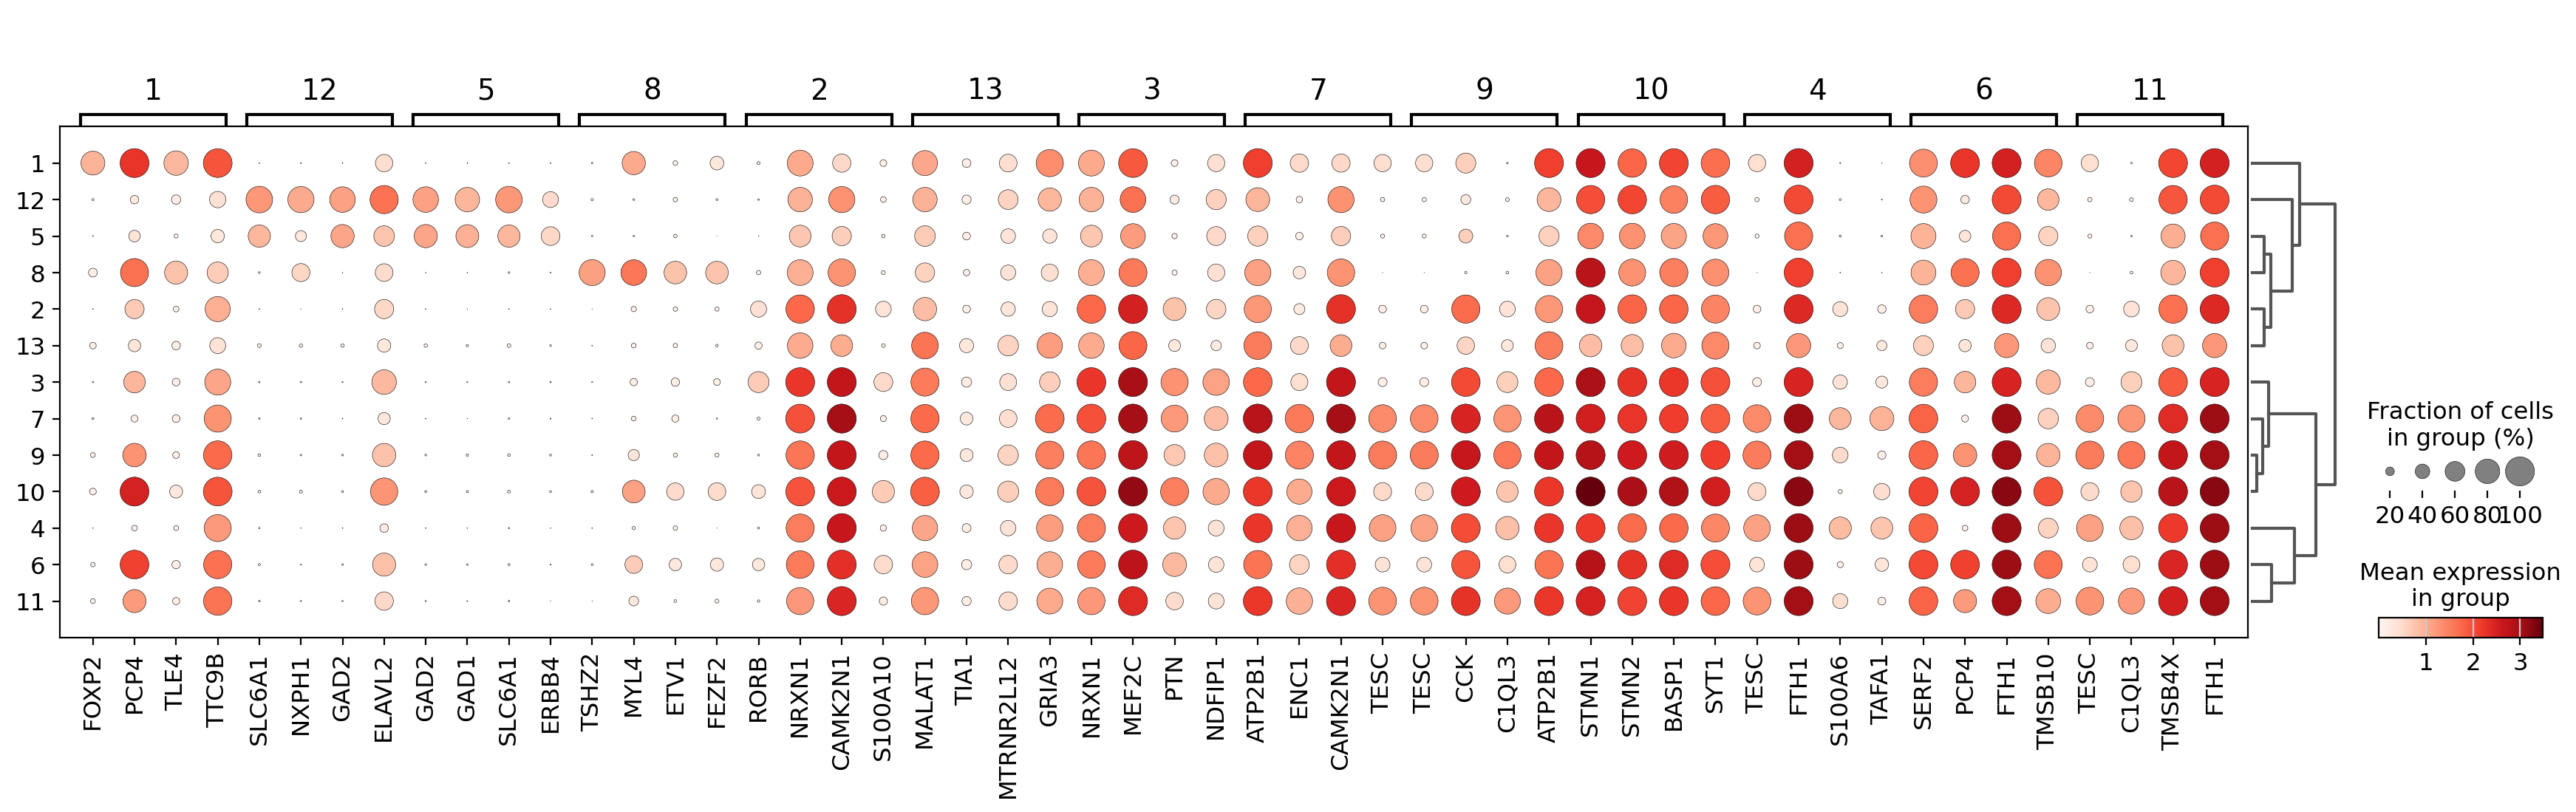

In [23]:
pbmc.var_names_make_unique()
sc.pl.rank_genes_groups_dotplot(pbmc, n_genes=4)

In order to get a better representation we can plot *log fold changes* instead of gene expression. Also, we want to focus on genes that have a log fold change >= 3 between the cell type expression and the rest of cells. 

In this case we set `values_to_plot='logfoldchanges'` and `min_logfoldchange=3`.

Because log fold change is a divergent scale we also adjust the min and max to be plotted and use a divergent color map. Notice in the following plot that is rather difficult to distinguish between T-cell populations.

### Visualize marker genes using matrixplot 

For the following plot the we use the previously computed 'scaled' values (stored in layer `scaled`) and use a divergent color map.

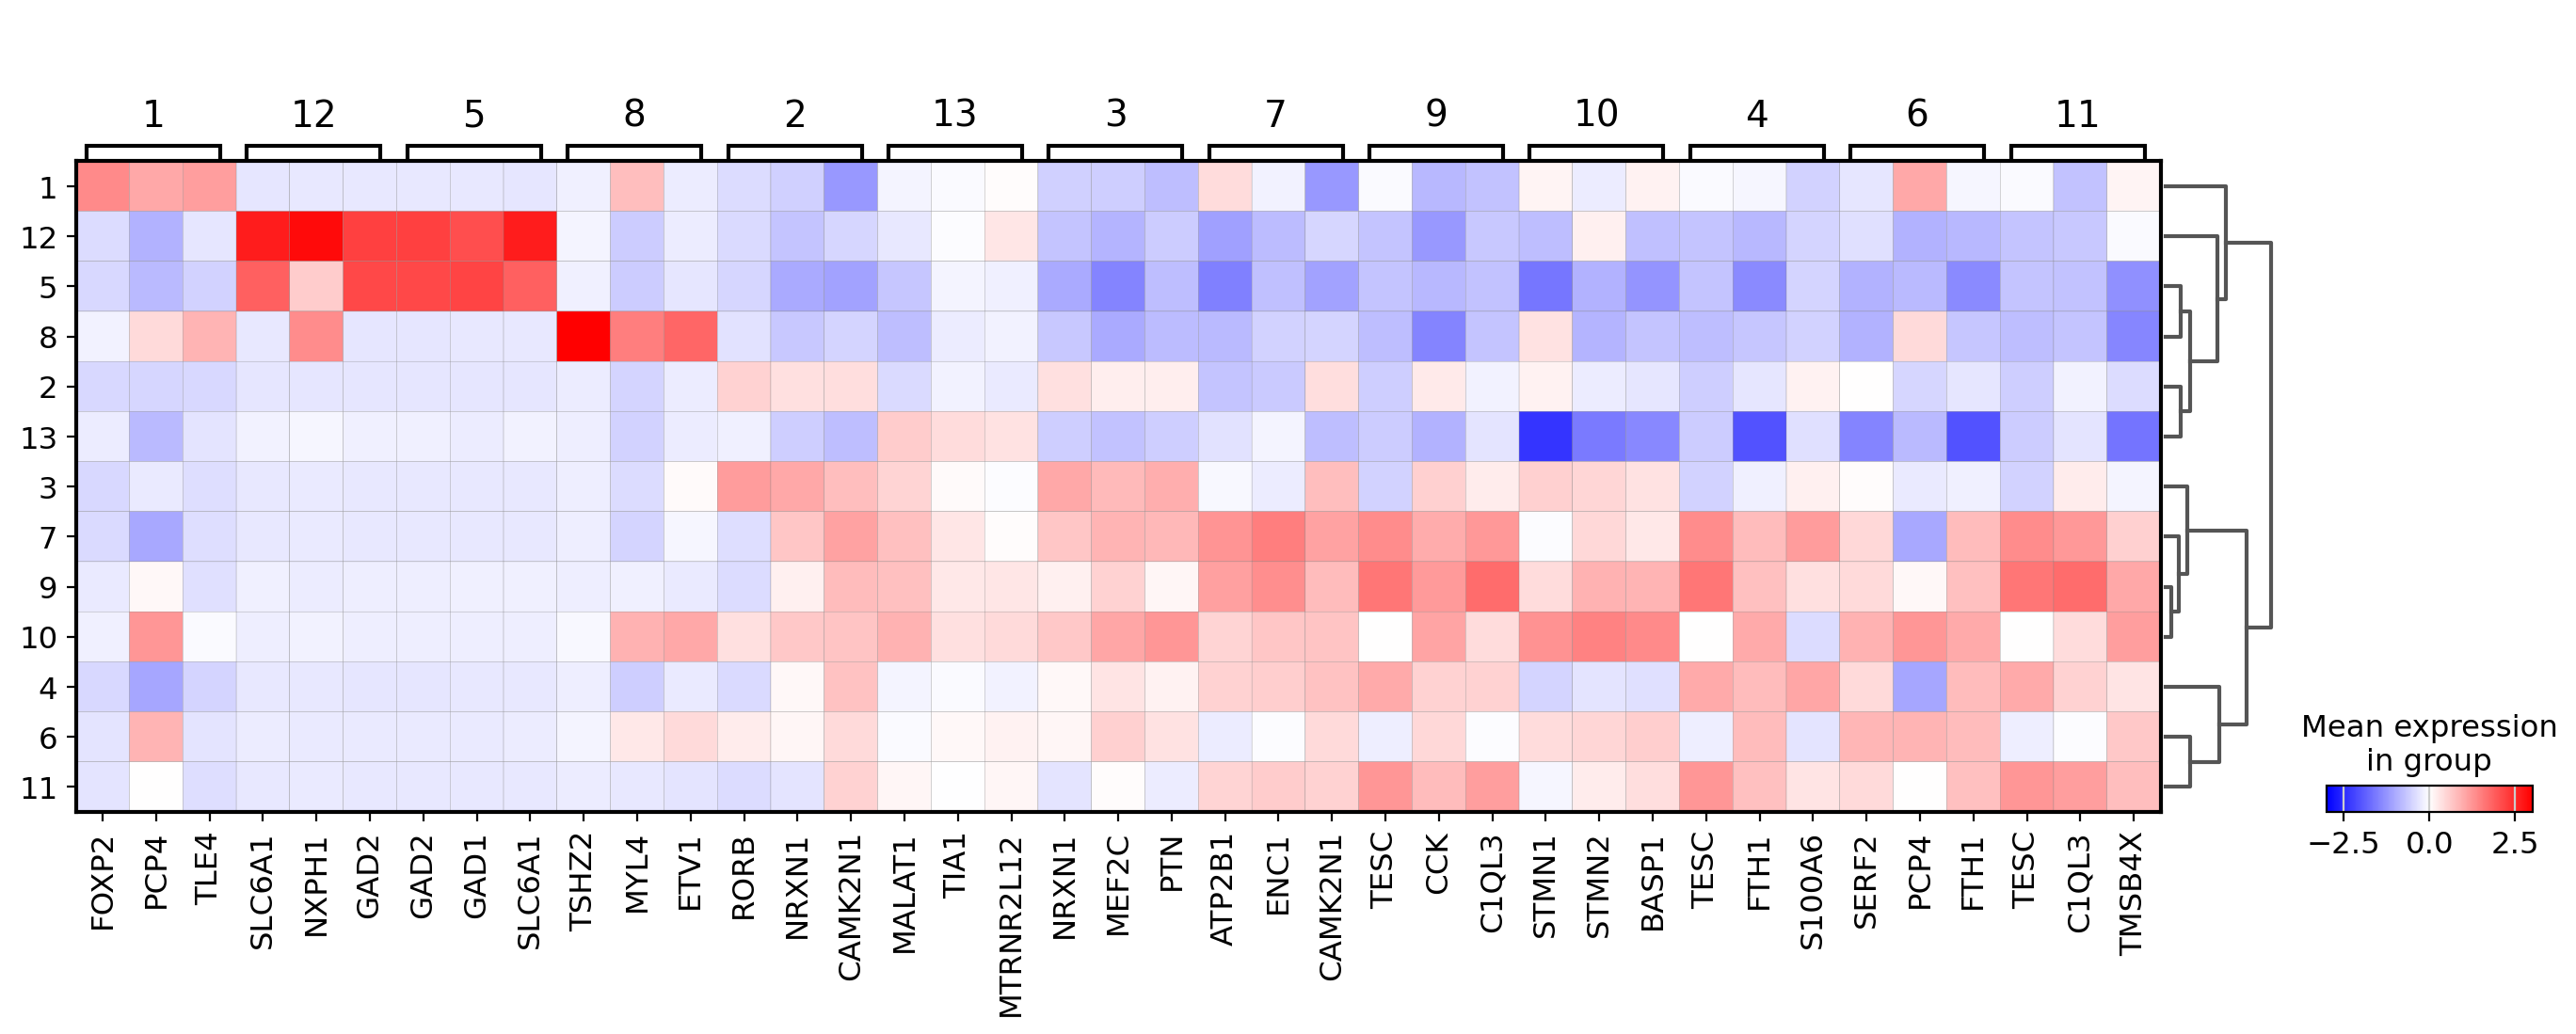

In [24]:
pbmc.layers['scaled'] = sc.pp.scale(pbmc, copy=True).X
sc.pl.rank_genes_groups_matrixplot(pbmc, n_genes=3, use_raw=False, vmin=-3, vmax=3, cmap='bwr', layer='scaled')

### Visualize marker genes using stacked violin plots

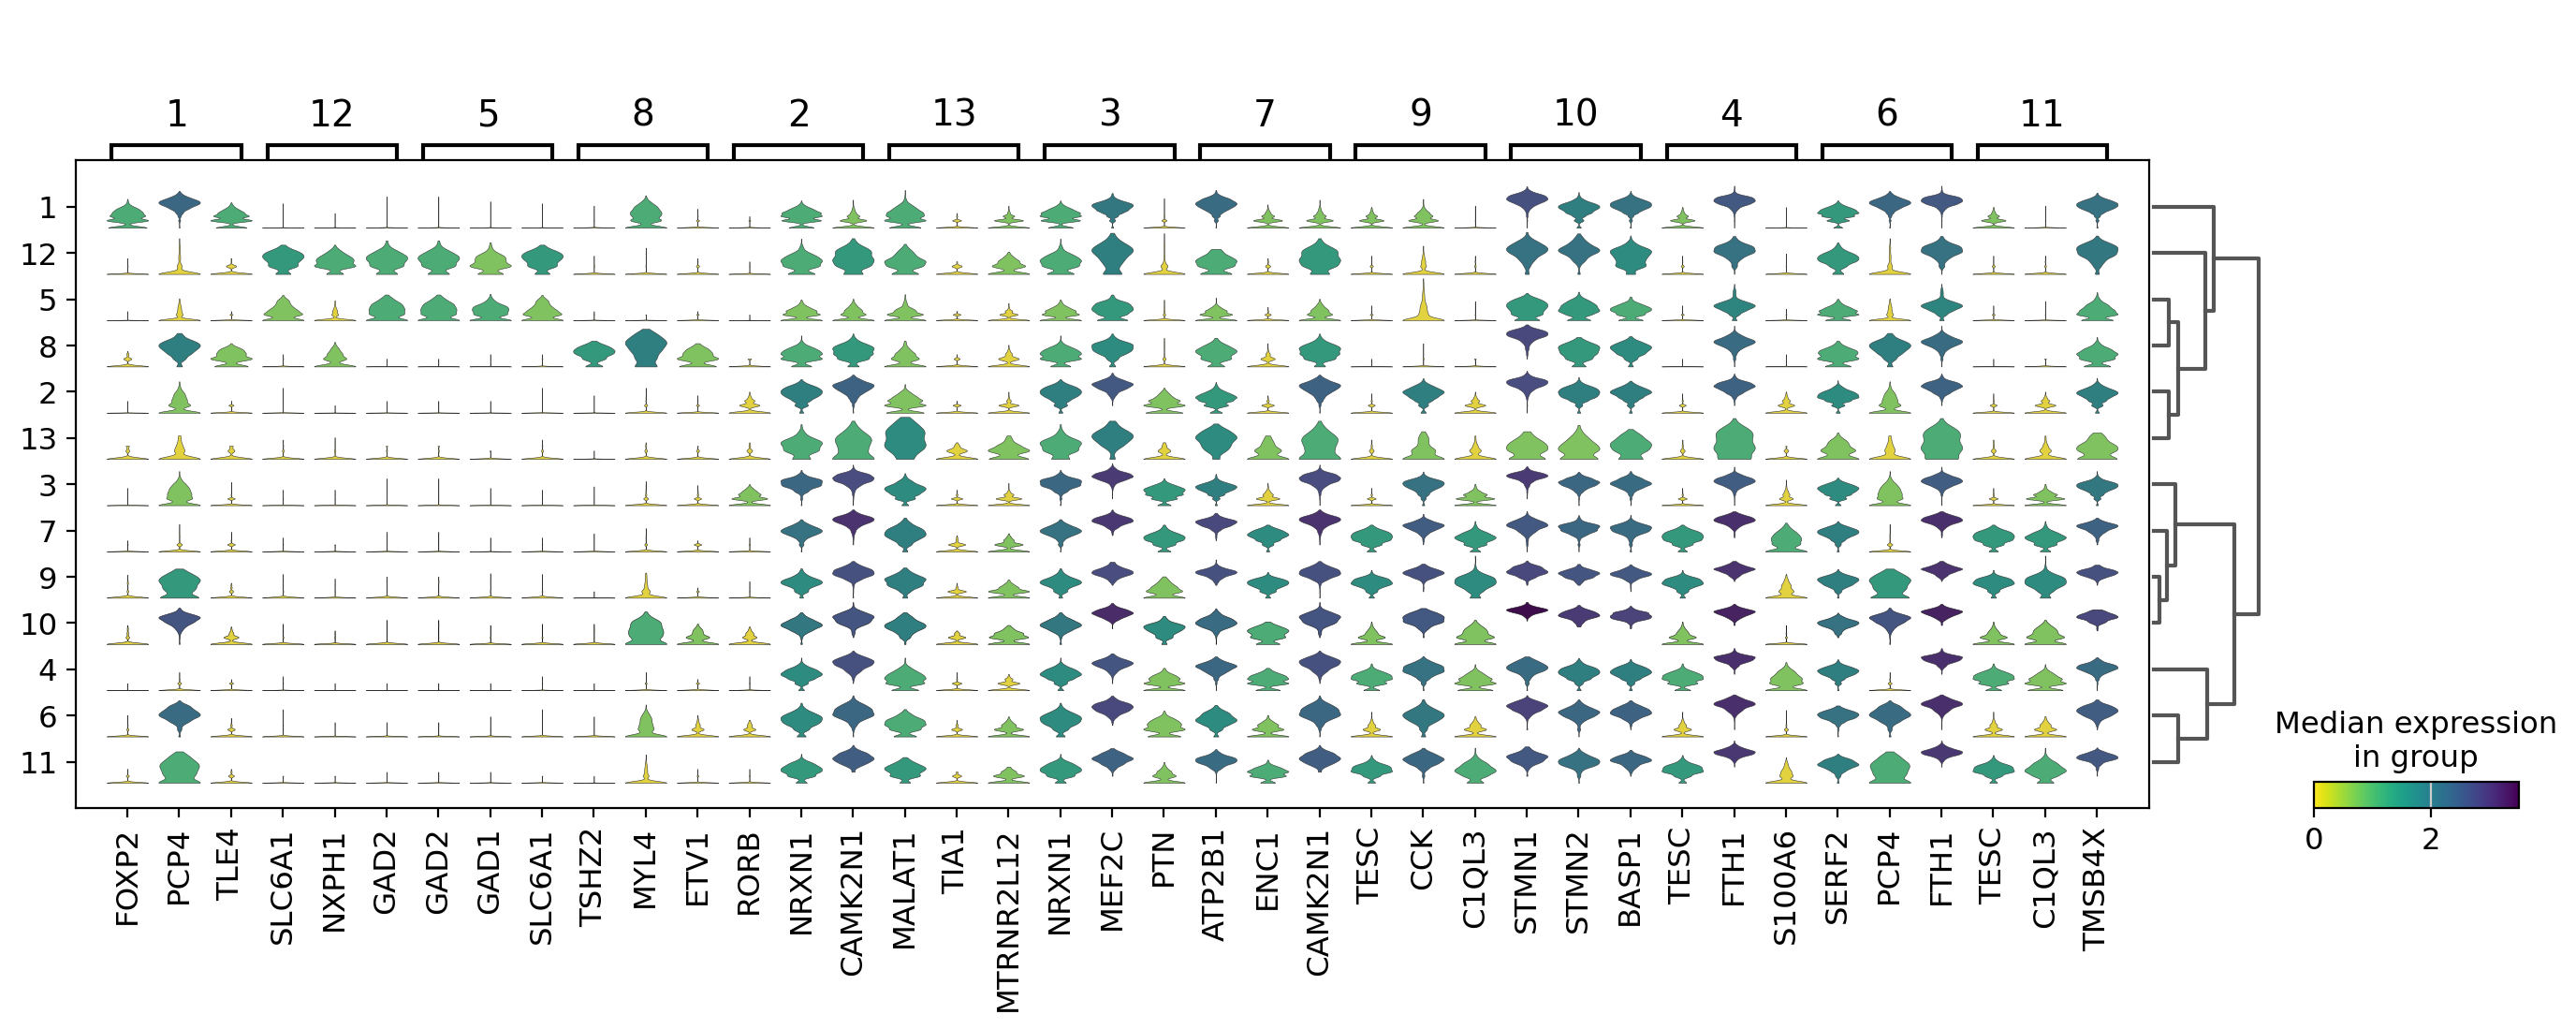

In [25]:
sc.pl.rank_genes_groups_stacked_violin(pbmc, n_genes=3, cmap='viridis_r')

### Visualize marker genes using heatmap

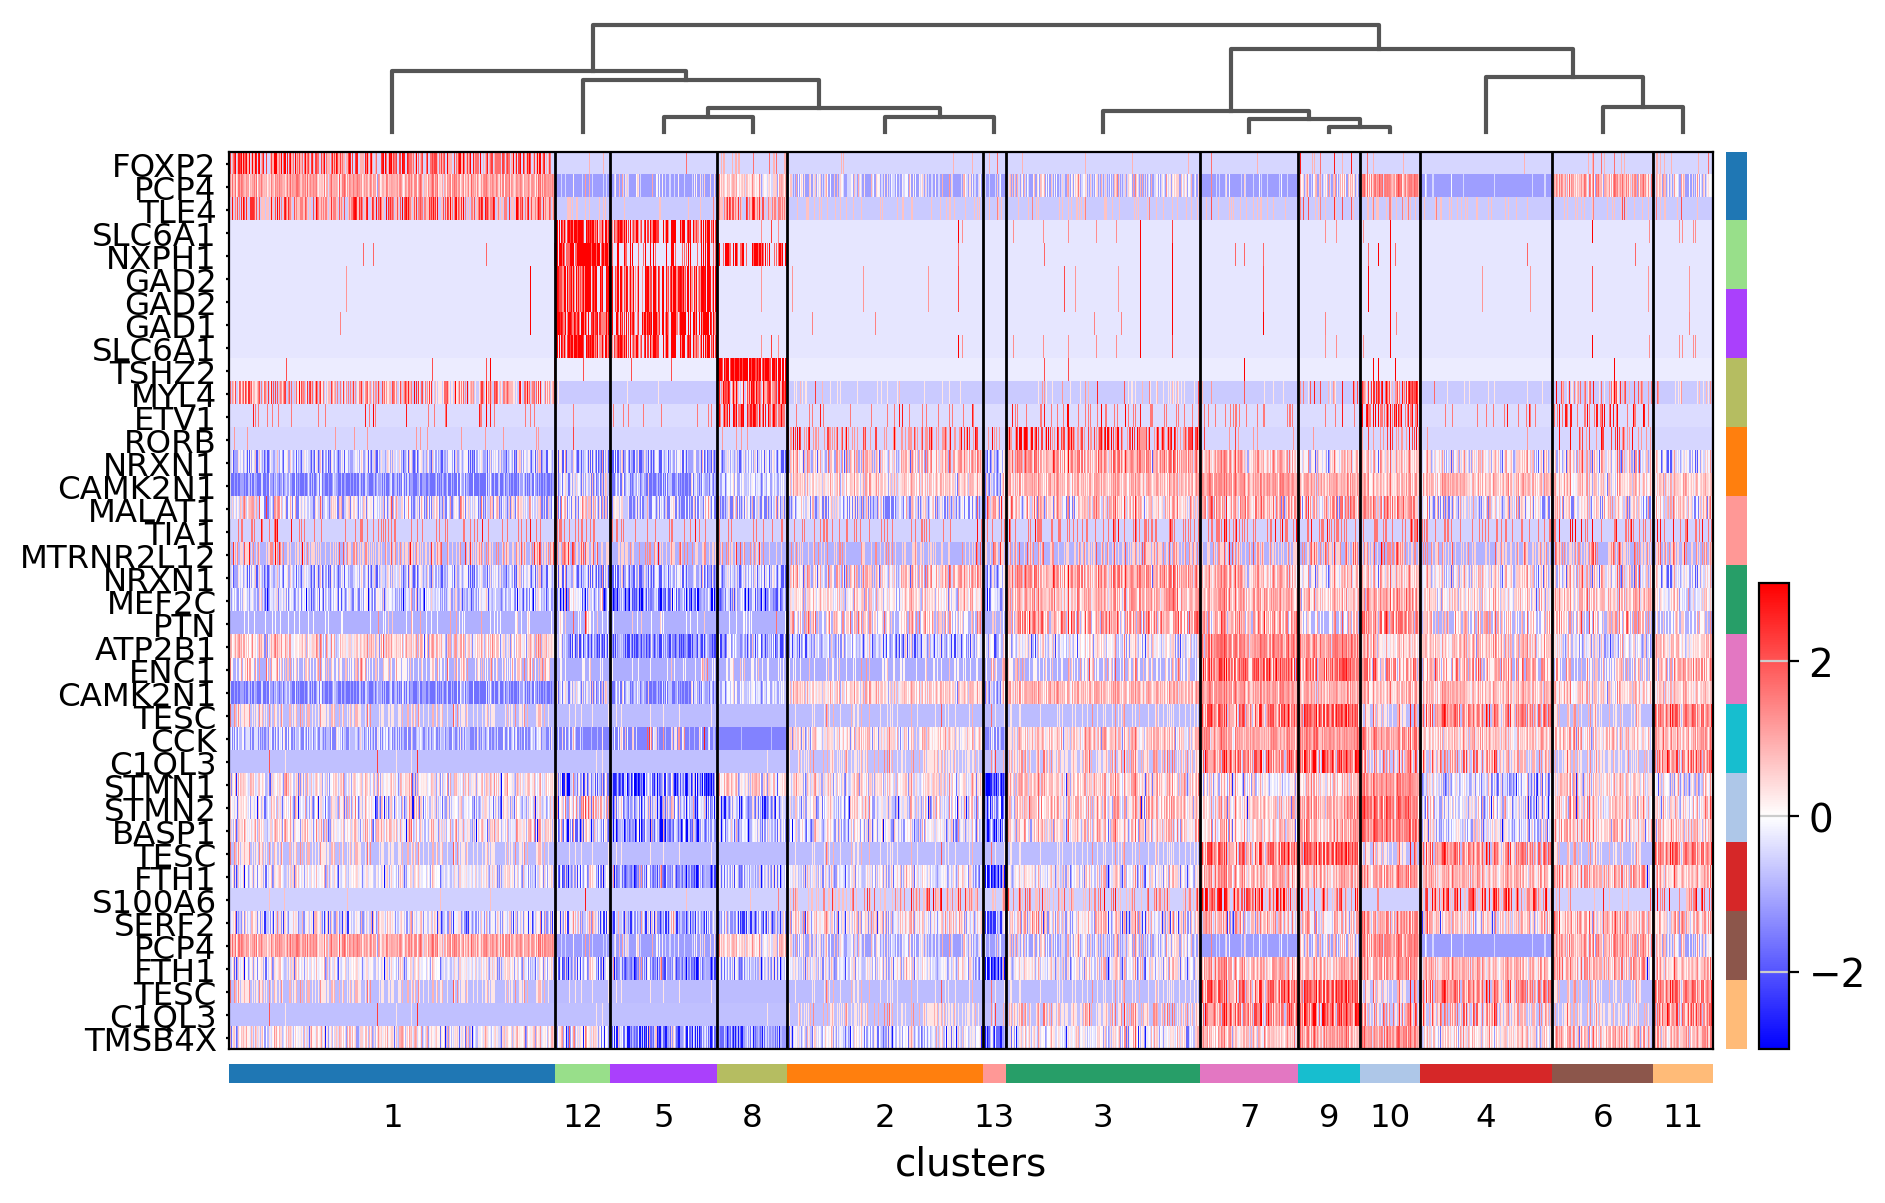

In [26]:
sc.pl.rank_genes_groups_heatmap(pbmc, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);

### Visualize marker genes using tracksplot

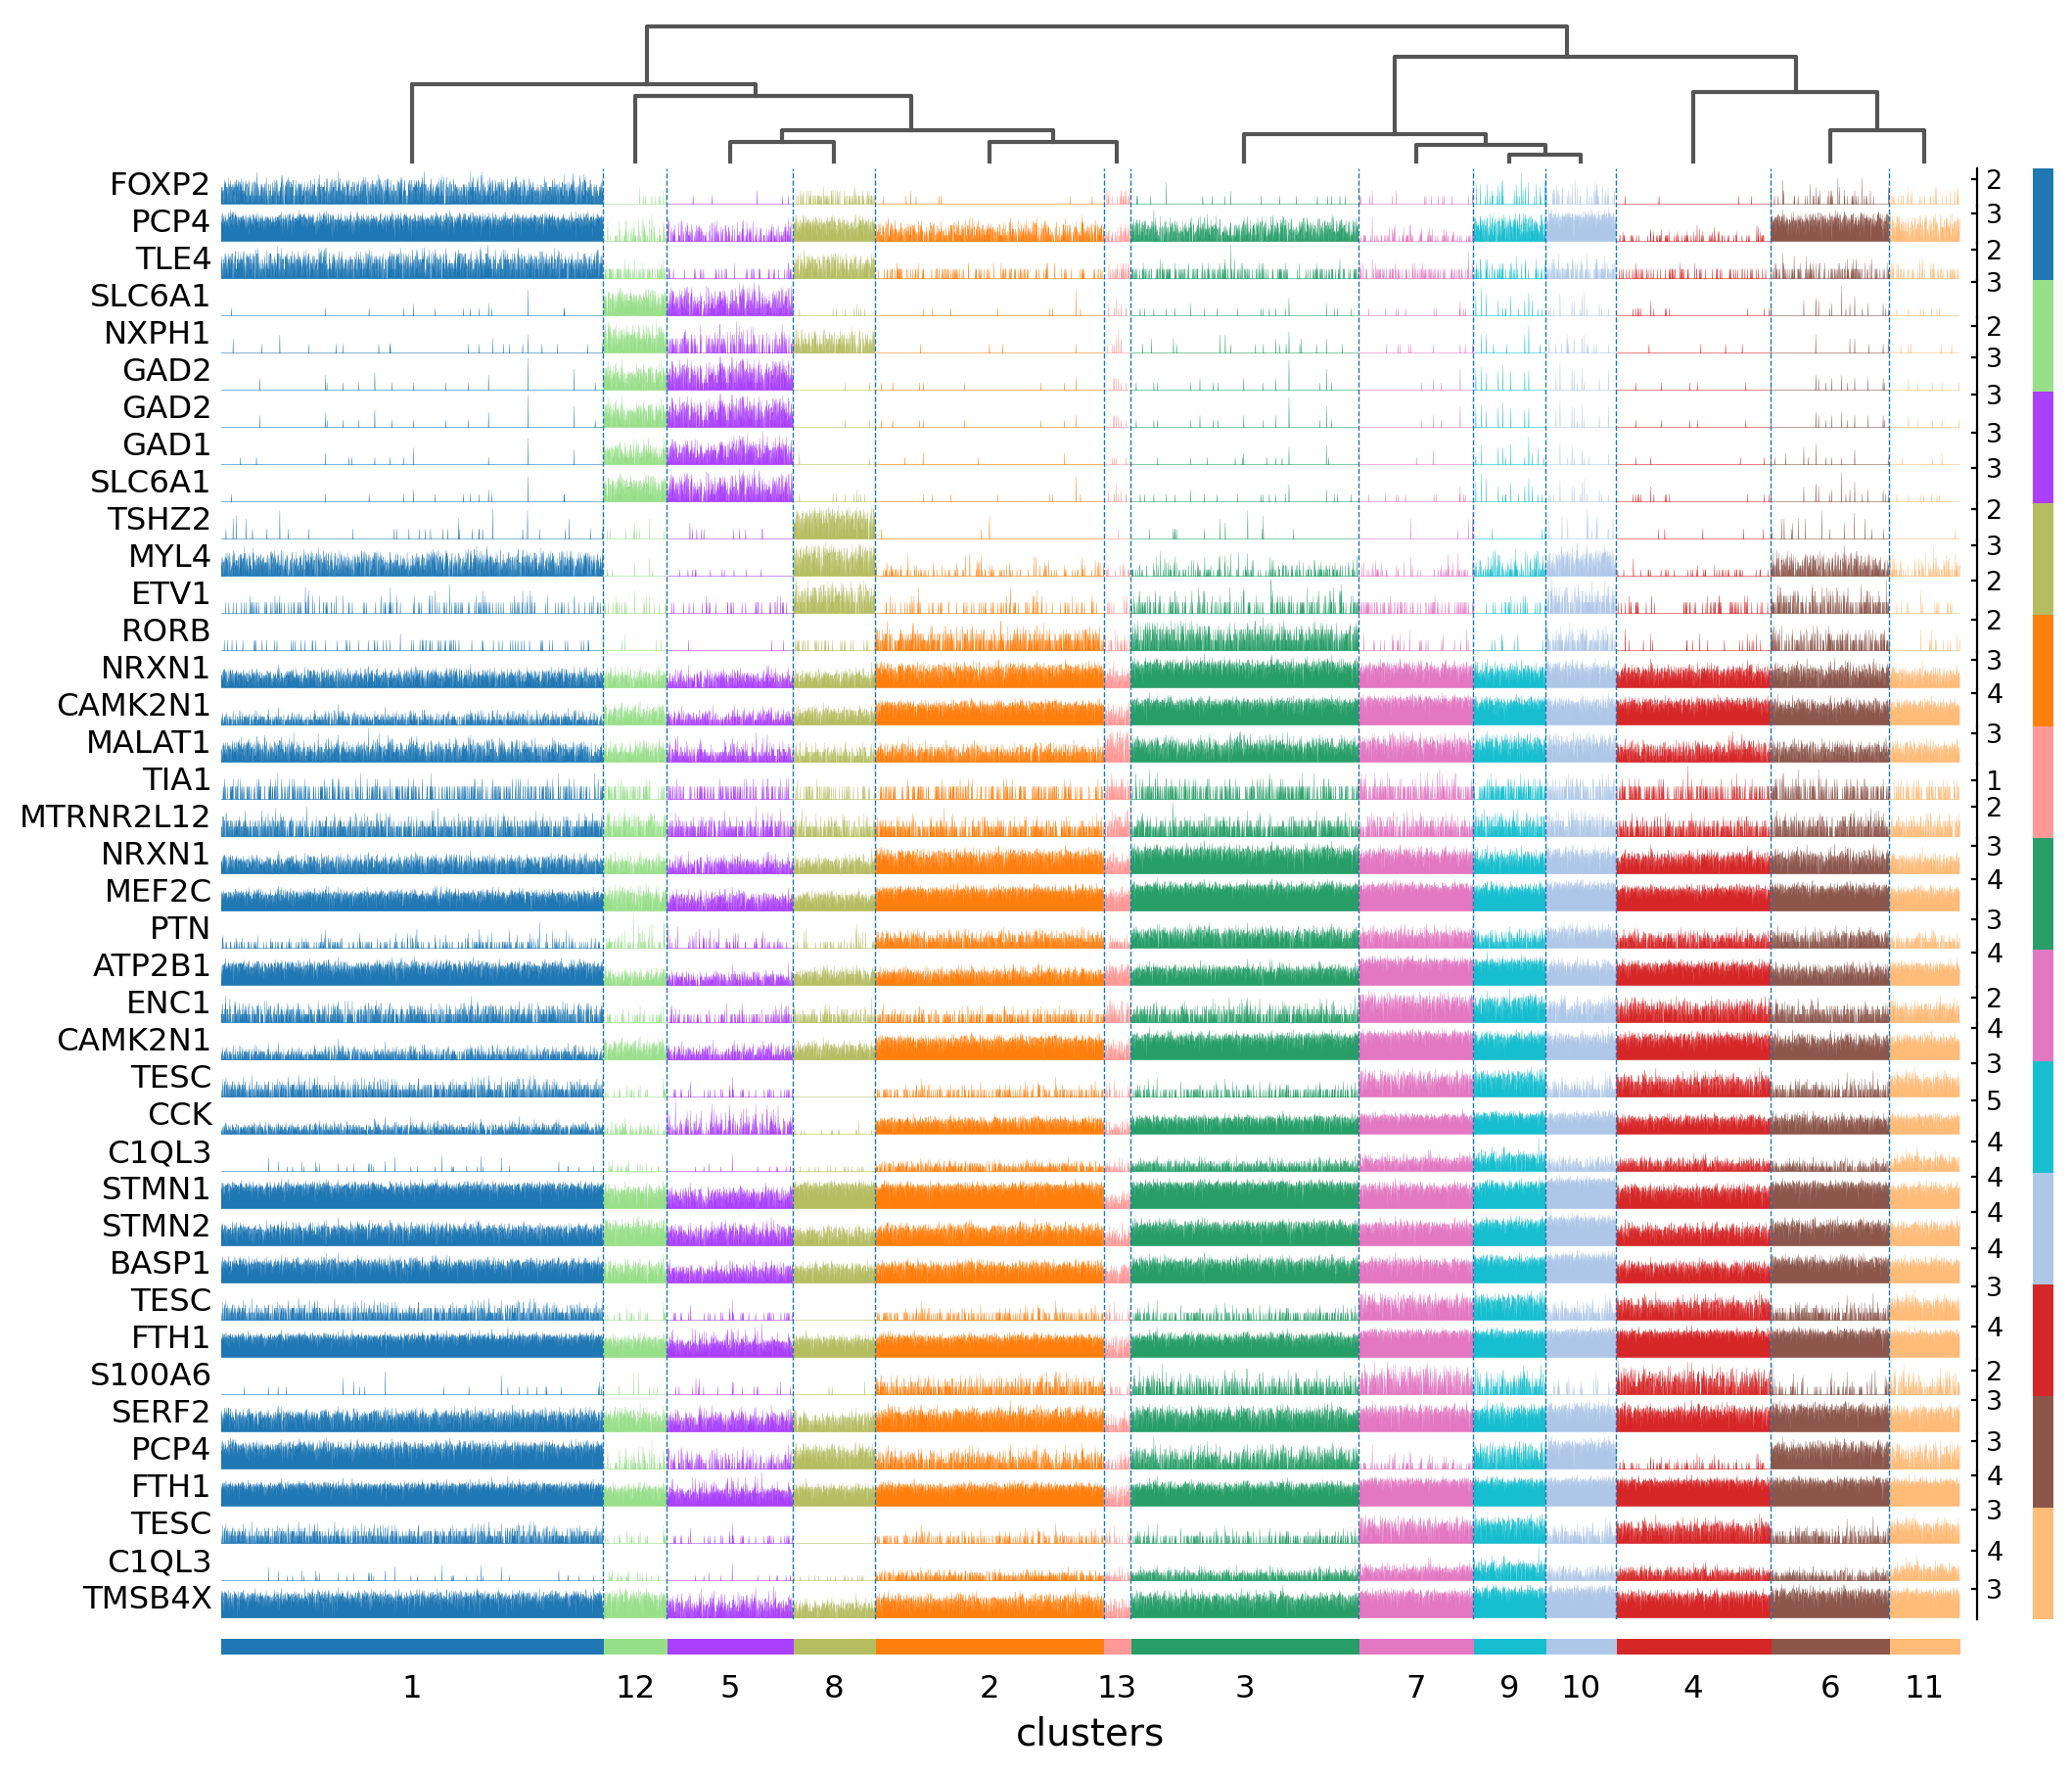

In [27]:
sc.pl.rank_genes_groups_tracksplot(pbmc, n_genes=3)

## Comparison of marker genes using split violin plots
In scanpy, is very easy to compare marker genes using split violin plots for all groups at once.

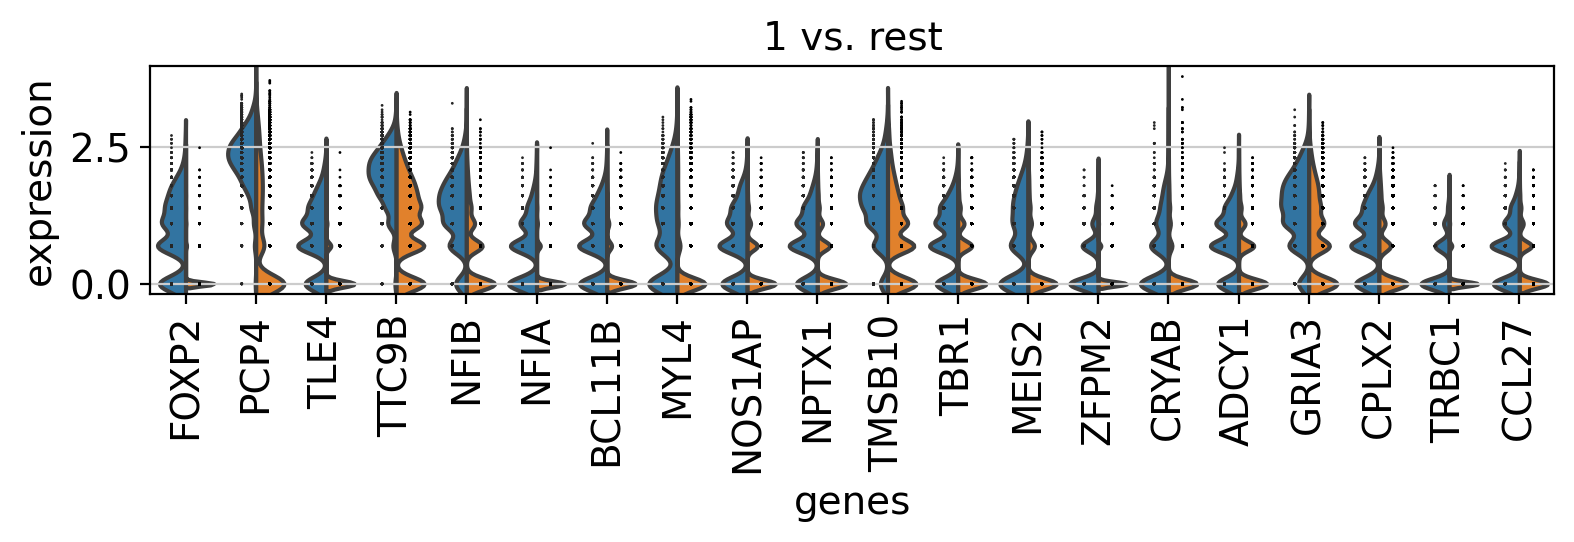

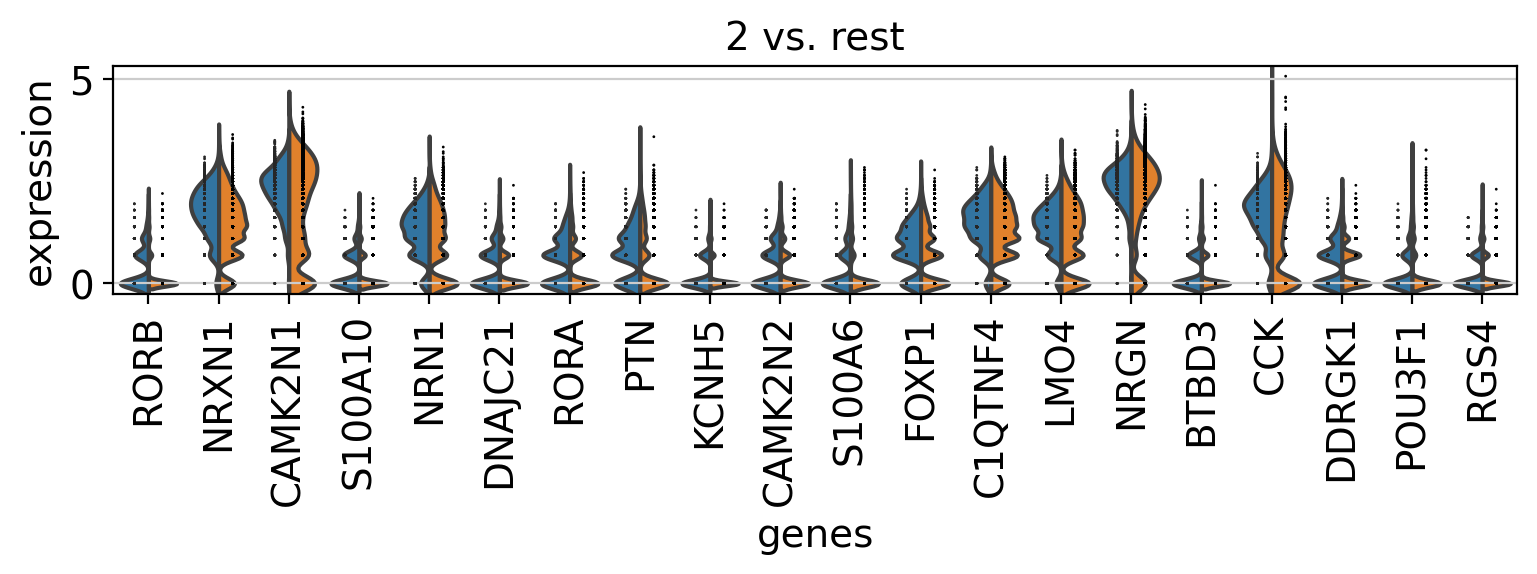

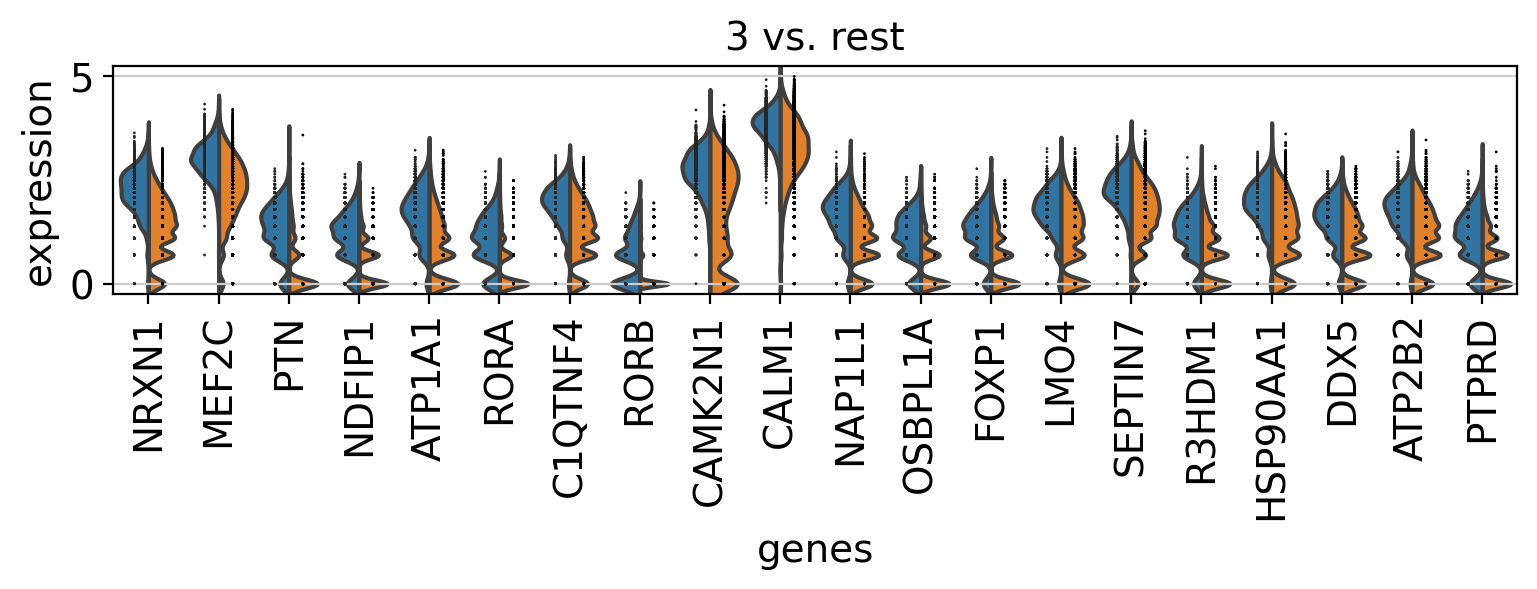

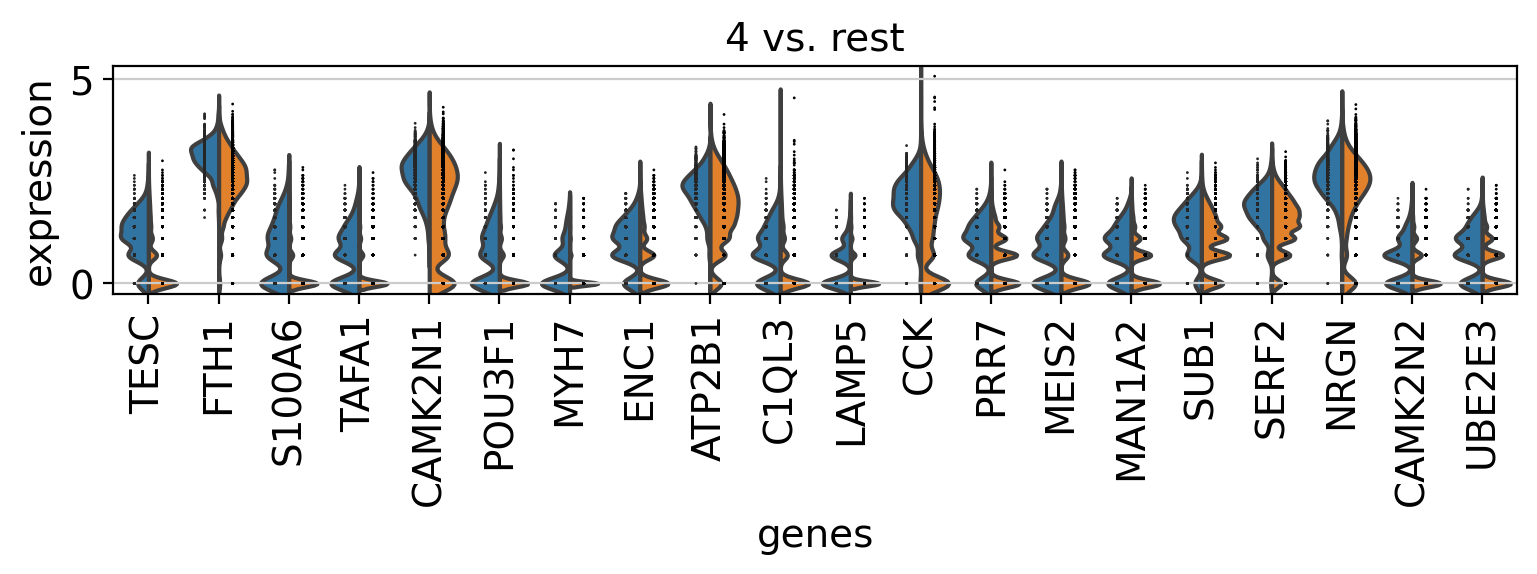

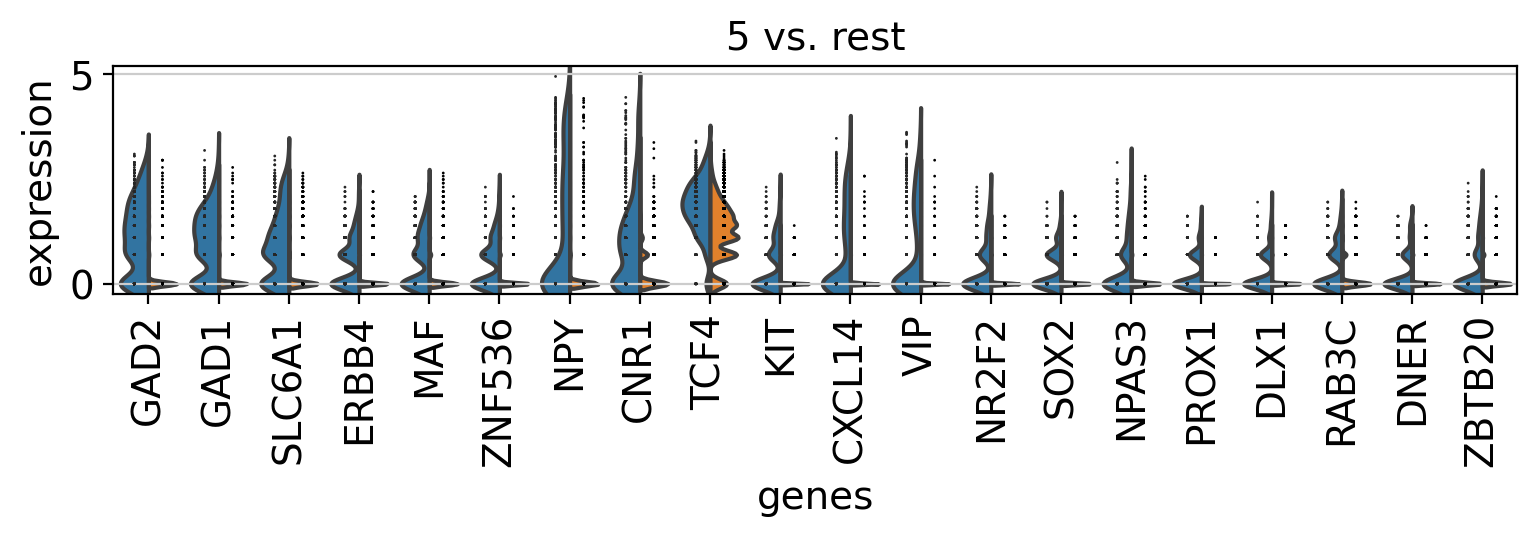

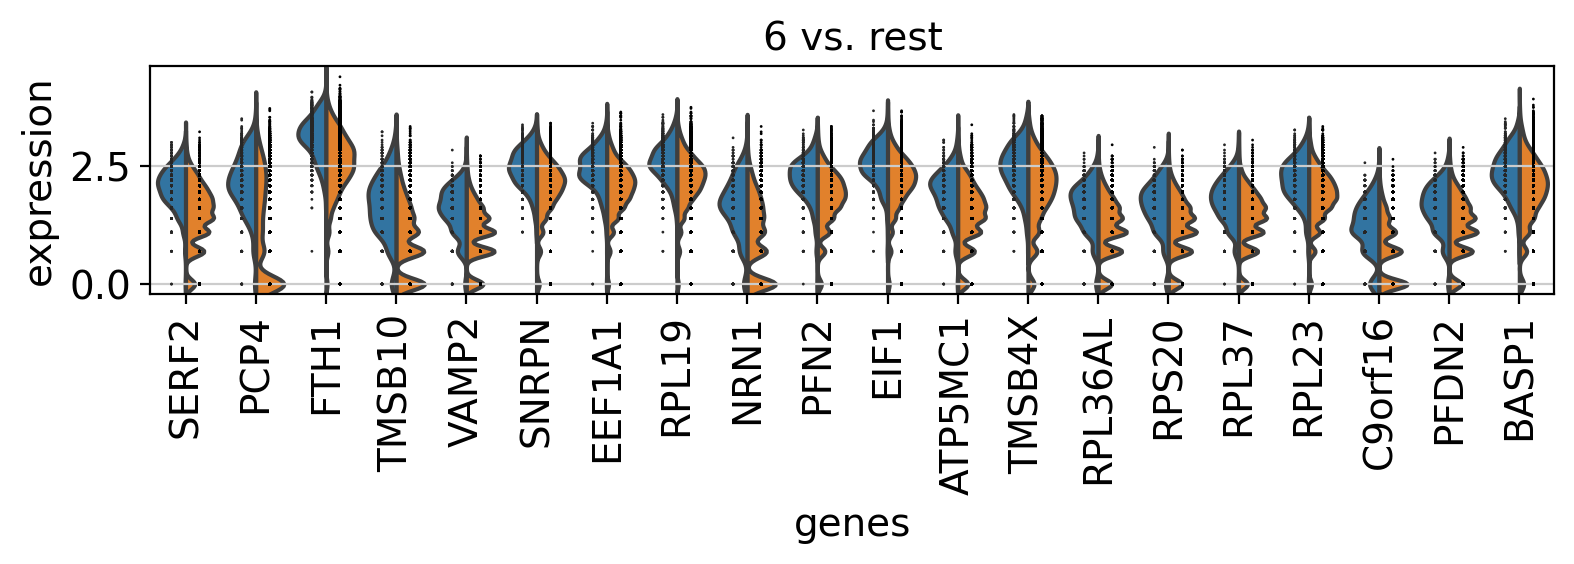

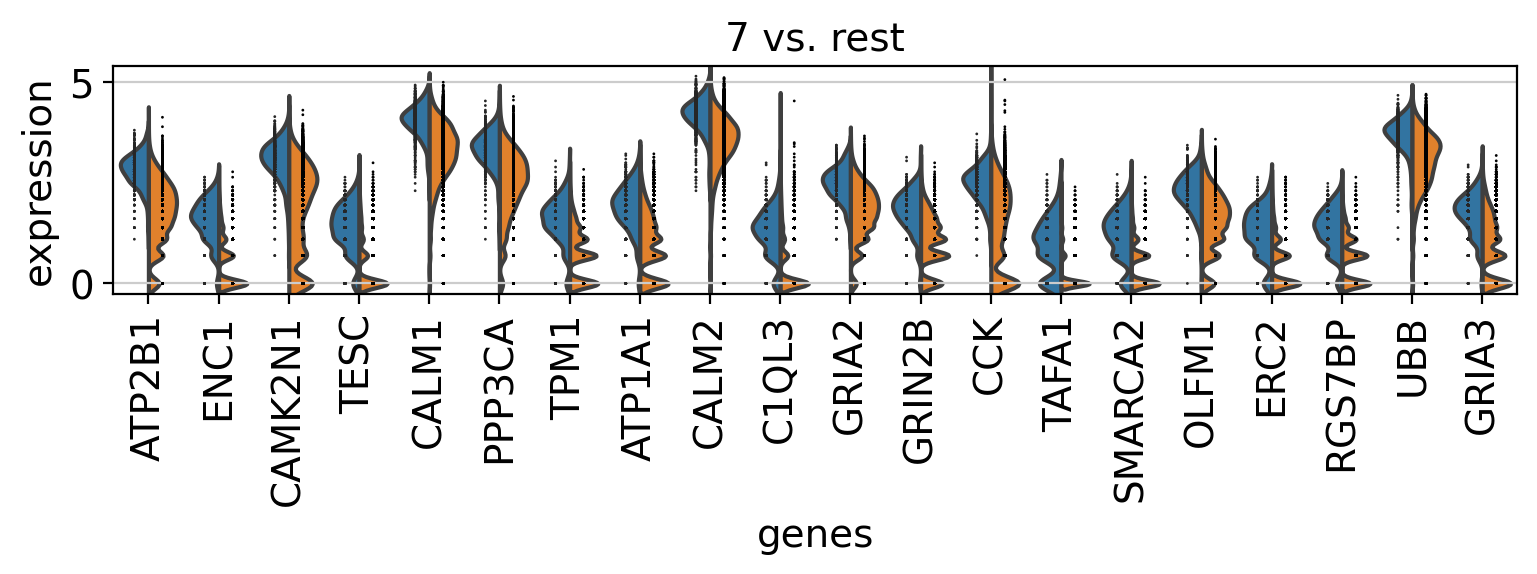

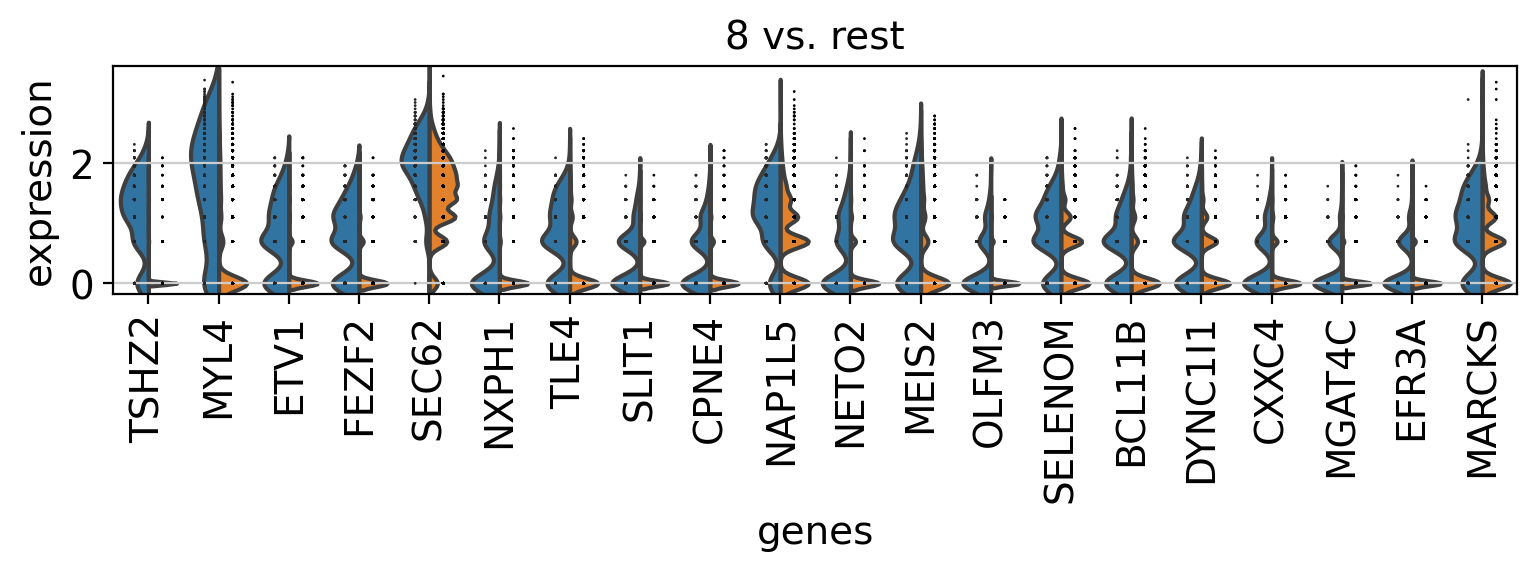

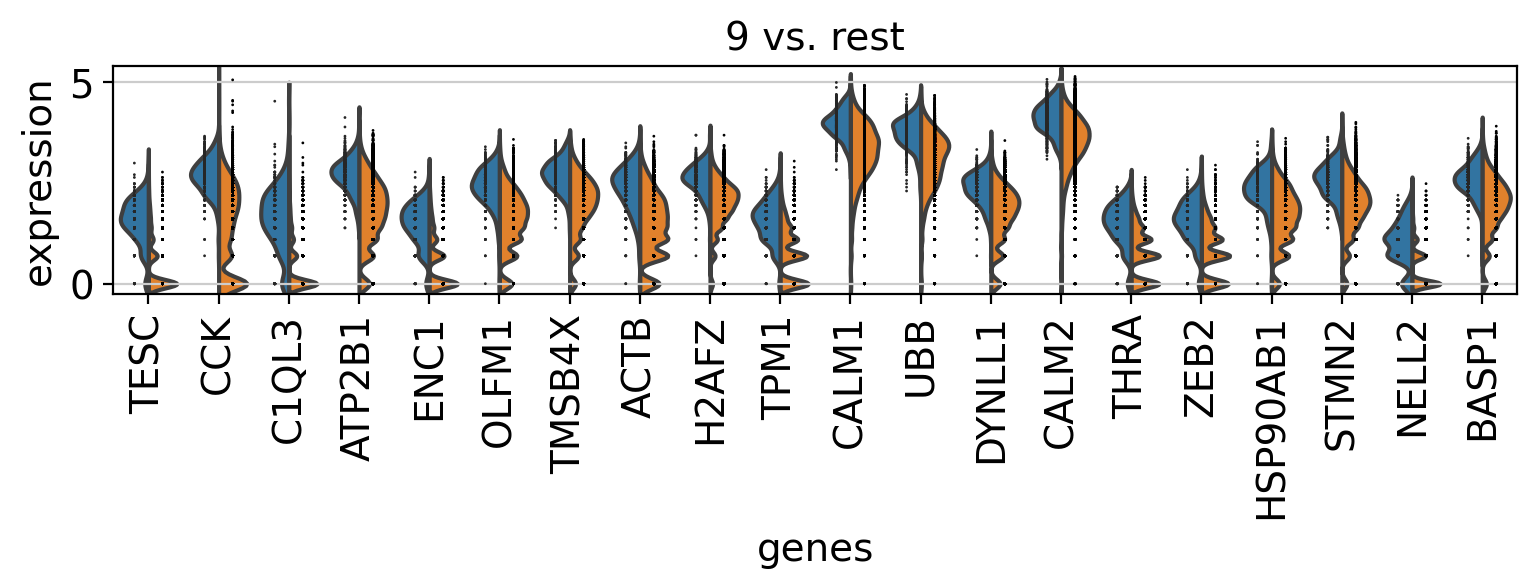

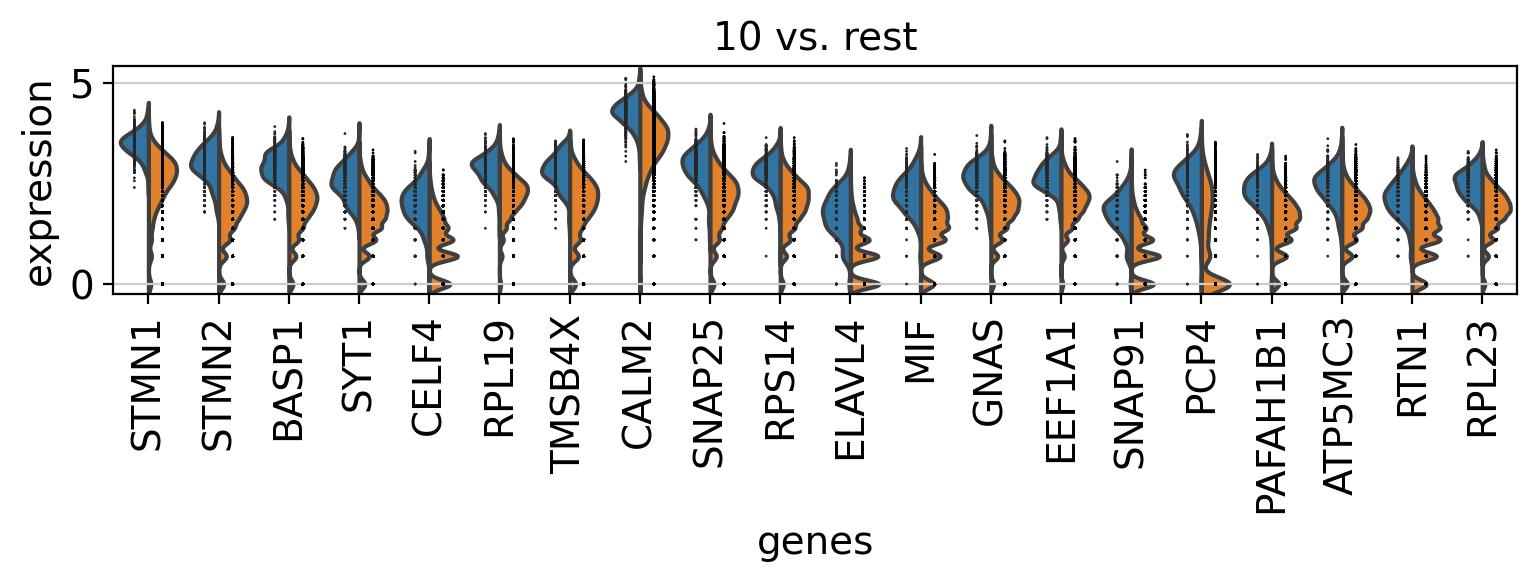

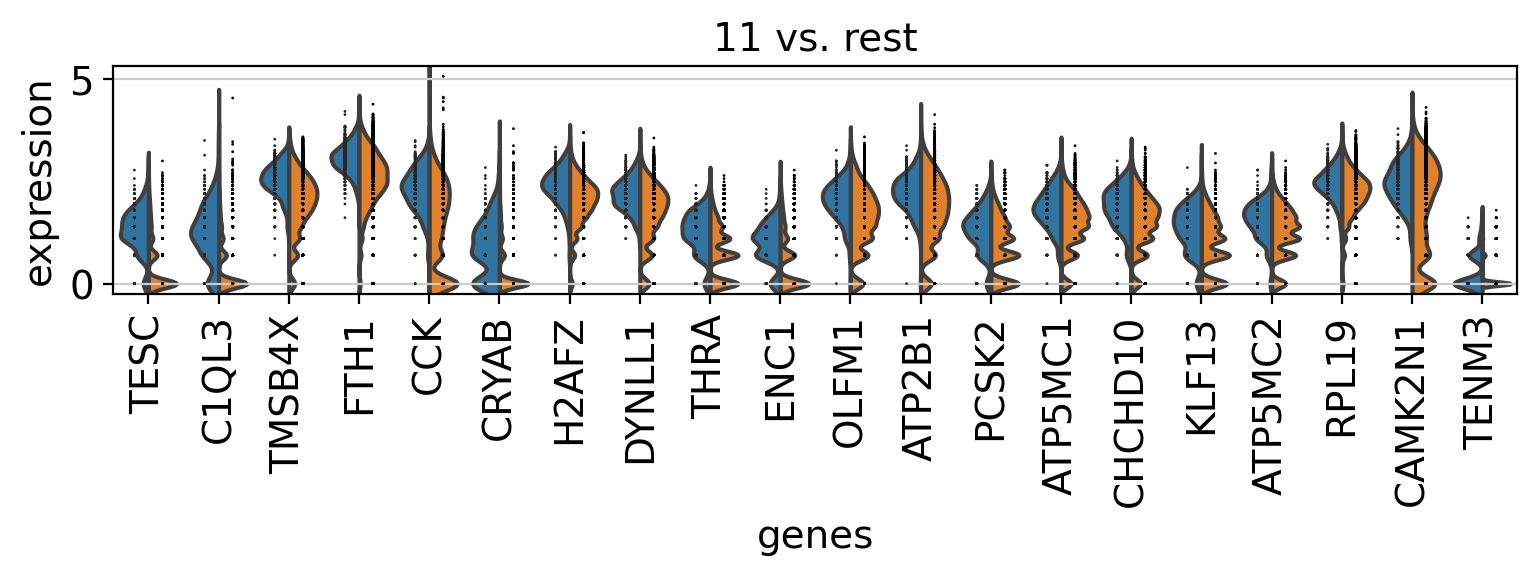

In [ ]:
with rc_context({'figure.figsize': (9, 1.5)}):
    sc.pl.rank_genes_groups_violin(pbmc, n_genes=20, jitter=False)